<a href="https://colab.research.google.com/github/pmontecinos23/Spanish-Wine-Evaluation/blob/main/Spanish_Wine_Evaluation_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spanish Wine Evaluation
Author: Paul Montecinos


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports below are temporary. I will filter through and clean it up once my data set is selected

In [2]:
## Pandas
import pandas as pd
## Numpy
import numpy as np
# MatPlotLib
import matplotlib.pyplot as plt
## seaborn
import seaborn as sns

## Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer


## Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

## Regression Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay



## Set global scikit-learn configuration 
from sklearn import set_config
## Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

## Loading Wine Data

### Data Source: 
https://www.kaggle.com/datasets/fedesoriano/spanish-wine-quality-dataset?resource=download

In [3]:
wine = pd.read_csv('/content/drive/MyDrive/Stack 2 Machine Learning/03 Week 3: Classification Models/Project 2/wines_SPA.csv')
wine.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


Brief Description: with 7500 different wines we can use this data to determining ratings and popularity of spanish wines

Target: Rating

Row represent: Wines

Classification or Regression: As an avid wine drinker, I would do a classification model determining the highest rated wines.

Features: There are 11 features in this dataset

In [4]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       7500 non-null   object 
 1   wine         7500 non-null   object 
 2   year         7498 non-null   object 
 3   rating       7500 non-null   float64
 4   num_reviews  7500 non-null   int64  
 5   country      7500 non-null   object 
 6   region       7500 non-null   object 
 7   price        7500 non-null   float64
 8   type         6955 non-null   object 
 9   body         6331 non-null   float64
 10  acidity      6331 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 644.7+ KB


In [5]:
# How many rows
print(f'Number of rows:{len(wine.axes[0])}')

Number of rows:7500


Challenges: 
* Total missing fields is 2885. Most of them are in the body and acidity type - determining what data I will fill into missing rows
* There are lot of objects in this data to potentially convert - Potentially cause overfitting - determining which features to drop


In [6]:
wine.shape
print(f'There are {wine.shape[0]} rows, and {wine.shape[1]} columns.')
print(f'The rows represent {wine.shape[0]} observations, and the columns represent {wine.shape[1]-1} features and 1 target variable.')

There are 7500 rows, and 11 columns.
The rows represent 7500 observations, and the columns represent 10 features and 1 target variable.


## Data Cleaning

In [7]:
## make columns lowercase for ease of reference and display names
wine.columns = wine.columns.str.lower()
wine.columns

Index(['winery', 'wine', 'year', 'rating', 'num_reviews', 'country', 'region',
       'price', 'type', 'body', 'acidity'],
      dtype='object')

### Checking for Duplicates

In [8]:
# checking for duplicates
wine.duplicated().sum()

5452

### Removing Duplicates

In [9]:
wine = wine.drop_duplicates()
wine.duplicated().sum()

0

In [10]:
wine.describe(exclude='number')

,winery,wine,year,country,region,type
count,2048,2048,2046,2048,2048,1942
unique,480,847,71,1,76,21
top,Vega Sicilia,Tinto,2016,Espana,Ribera del Duero,Ribera Del Duero Red
freq,97,56,243,2048,541,535


In [11]:
wine = wine.drop(columns='country')

In [12]:
# checking breadown of numeric columns
wine.describe()

,rating,num_reviews,price,body,acidity
count,2048.000000,2048.000000,2048.000000,1777.000000,1777.000000
mean,4.401123,573.994629,135.242194,4.258863,2.921216
std,0.147023,1376.153171,272.178316,0.652836,0.334713
min,4.200000,25.000000,4.990000,2.000000,1.000000
25%,4.300000,58.000000,31.917947,4.000000,3.000000
50%,4.400000,141.000000,53.625000,4.000000,3.000000
75%,4.500000,485.500000,110.000000,5.000000,3.000000
max,4.900000,32624.000000,3119.080000,5.000000,3.000000


### Checking for categorical errors

In [13]:
# Inspect categorical columns for errors
cat_cols = make_column_selector(dtype_include='object')(wine)
for col in cat_cols:
  display(wine[col].value_counts(normalize=True))

Vega Sicilia                            0.047363
Alvaro Palacios                         0.023438
Artadi                                  0.020996
La Rioja Alta                           0.017578
Marques de Murrieta                     0.016113
                                          ...   
Valdelosfrailes                         0.000488
Briego                                  0.000488
Guillem Carol - Cellers Carol Valles    0.000488
Particular                              0.000488
Binigrau                                0.000488
Name: winery, Length: 480, dtype: float64

Tinto                                                 0.027344
Unico                                                 0.020020
Valbuena 5o                                           0.015625
Reserva                                               0.015137
Priorat                                               0.012695
                                                        ...   
San Valentin Parellada                                0.000488
Silvanus Edicion Limitada Ribera del Duero            0.000488
El Jardin de las Iguales Vinedo Historico Garnacha    0.000488
Garnacha Vinas Centenarias                            0.000488
Capricho Crianza                                      0.000488
Name: wine, Length: 847, dtype: float64

2016    0.118768
2017    0.117302
2015    0.100684
2018    0.095797
2014    0.077224
          ...   
1953    0.000489
1972    0.000489
1974    0.000489
1931    0.000489
1925    0.000489
Name: year, Length: 71, dtype: float64

Ribera del Duero                   0.264160
Rioja                              0.233887
Priorato                           0.122070
Toro                               0.040039
Castilla y Leon                    0.024902
                                     ...   
Ribera del Gallego-Cinco Villas    0.000488
Monterrei                          0.000488
Jerez Cream                        0.000488
Condado de Huelva                  0.000488
Abona                              0.000488
Name: region, Length: 76, dtype: float64

Ribera Del Duero Red    0.275489
Rioja Red               0.232235
Priorat Red             0.122554
Red                     0.108136
Toro Red                0.040165
Tempranillo             0.037590
Sherry                  0.028836
Rioja White             0.019053
Pedro Ximenez           0.018023
Grenache                0.018023
Albarino                0.017508
Cava                    0.016993
Verdejo                 0.013903
Monastrell              0.009269
Mencia                  0.008754
Montsant Red            0.008754
Syrah                   0.007724
Chardonnay              0.006694
Cabernet Sauvignon      0.005664
Sparkling               0.002575
Sauvignon Blanc         0.002060
Name: type, dtype: float64

### Checking for missing values

In [14]:
wine.isna().sum()

winery           0
wine             0
year             2
rating           0
num_reviews      0
region           0
price            0
type           106
body           271
acidity        271
dtype: int64

In [15]:
wine[wine.isna().any(axis = 1)]

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity
46,Vega Sicilia,Unico Reserva Especial Edicion,NaN,4.7,12421,Ribera del Duero,423.50000,Ribera Del Duero Red,5.0,3.0
120,Finca Moncloa,Tintilla de Rota,2016,4.7,92,Cadiz,43.13000,NaN,NaN,NaN
147,Rafael Palacios,Sorte O Soro Val do Bibei,2019,4.7,37,Valdeorras,194.86000,NaN,NaN,NaN
156,Gutierrez de la Vega,Recondita Armonia Monastrell Dulce,1987,4.7,27,Alicante,81.90000,NaN,NaN,NaN
254,Costers del Siurana,Dolc de L'Obac,2006,4.6,94,Priorato,117.23942,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021,Mustiguillo,Finca Terrerazo,2017,4.2,390,El Terrerazo,24.45000,Red,NaN,NaN
2022,Matarromera,Gran Reserva,2011,4.2,389,Ribera del Duero,64.50000,Ribera Del Duero Red,NaN,NaN
2023,Sei Solo,Preludio,2016,4.2,388,Ribera del Duero,31.63000,Ribera Del Duero Red,NaN,NaN
2024,Vinedos de Paganos,El Puntido,2005,4.2,384,Rioja,73.00000,Rioja Red,NaN,NaN


In [16]:
# Dropping columns 
wine1 = wine.drop(columns=['wine', 'year', 'winery','region'])
wine1.head()

,rating,num_reviews,price,type,body,acidity
0,4.9,58,995.00,Toro Red,5.0,3.0
1,4.9,31,313.50,Tempranillo,4.0,2.0
2,4.8,1793,324.95,Ribera Del Duero Red,5.0,3.0
3,4.8,1705,692.96,Ribera Del Duero Red,5.0,3.0
4,4.8,1309,778.06,Ribera Del Duero Red,5.0,3.0


Creating a new dataframe and dropping a few columns for exploratory visuals.

Will address the rest of the missing values during preprocessing.

I may bring back the dropped columns before splitting for train test split.

In [17]:
wine1.value_counts()

rating  num_reviews  price   type                  body  acidity
4.2     151          28.90   Grenache              5.0   3.0        1
4.5     32           34.50   Verdejo               3.0   3.0        1
        36           20.15   Red                   4.0   3.0        1
        35           157.00  Ribera Del Duero Red  5.0   3.0        1
        34           295.00  Pedro Ximenez         5.0   1.0        1
                                                                   ..
4.3     260          63.95   Rioja Red             4.0   3.0        1
        258          12.90   Rioja Red             4.0   3.0        1
        251          107.74  Ribera Del Duero Red  5.0   3.0        1
        249          162.50  Priorat Red           4.0   3.0        1
4.9     58           995.00  Toro Red              5.0   3.0        1
Length: 1777, dtype: int64

In [18]:
wine1['rating'].value_counts()

4.3    706
4.4    484
4.5    281
4.2    228
4.6    191
4.7    112
4.8     44
4.9      2
Name: rating, dtype: int64

### Histogram for each numeric variable

following Histplots were adapted from: https://www.python-graph-gallery.com/20-basic-histogram-seaborn 

### Ratings histplot

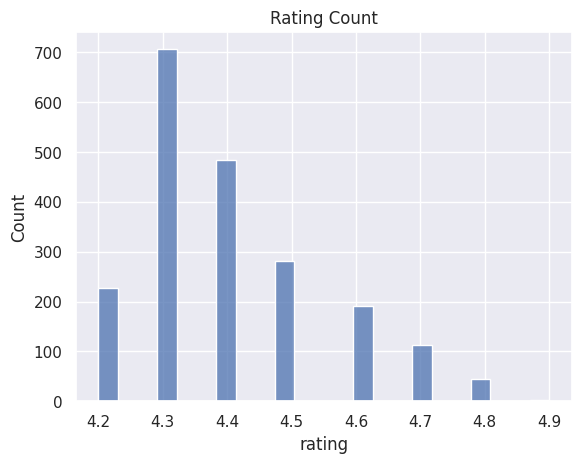

In [19]:
sns.set(style="darkgrid")

sns.histplot(data=wine1, x="rating").set_title('Rating Count')
plt.show()

Wine ratings by count

706 wines have been rated 4.3. This represents most of the wines in the data set.

44 wines were rated 4.8 representing the 2nd least rating frquency.


### Price histplot

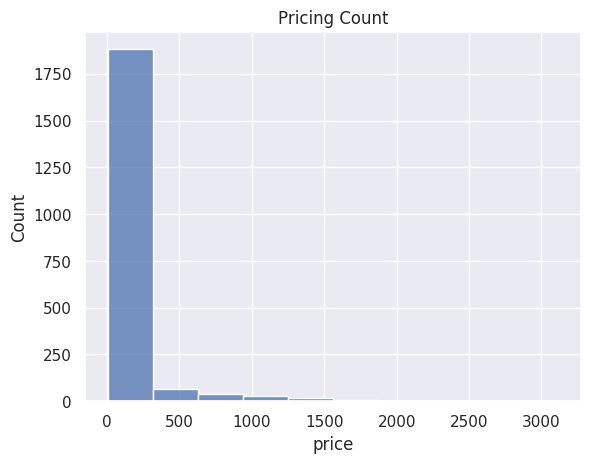

In [20]:
sns.set(style="darkgrid")

sns.histplot(data=wine1, x="price", bins=10).set_title('Pricing Count')
plt.show()

### Body histplot

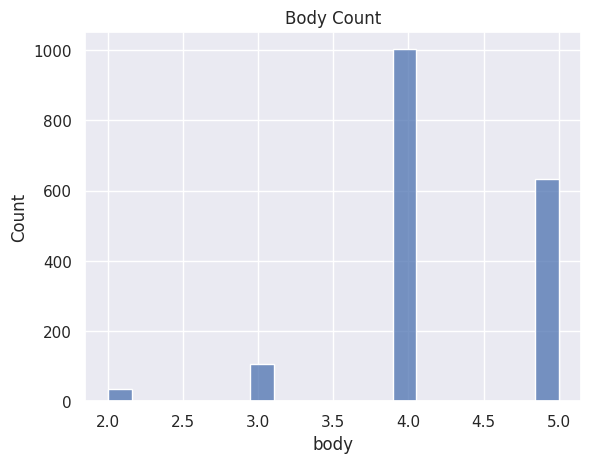

In [21]:
sns.set(style="darkgrid")

sns.histplot(data=wine1, x="body").set_title('Body Count')
plt.show()

### Acidity histplot

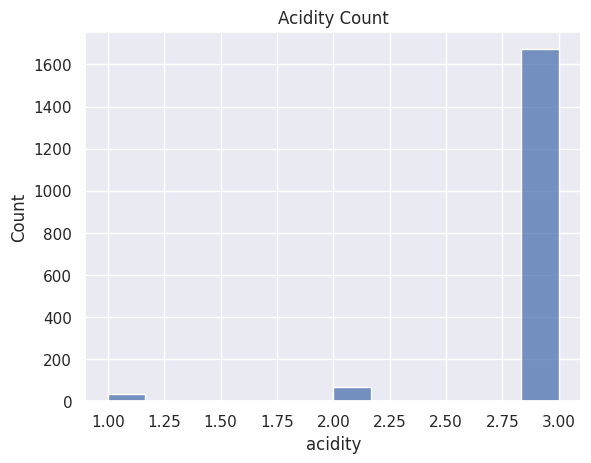

In [22]:
sns.set(style="darkgrid")

sns.histplot(data=wine1, x="acidity").set_title('Acidity Count')
plt.show()

### Number of reviews histplot

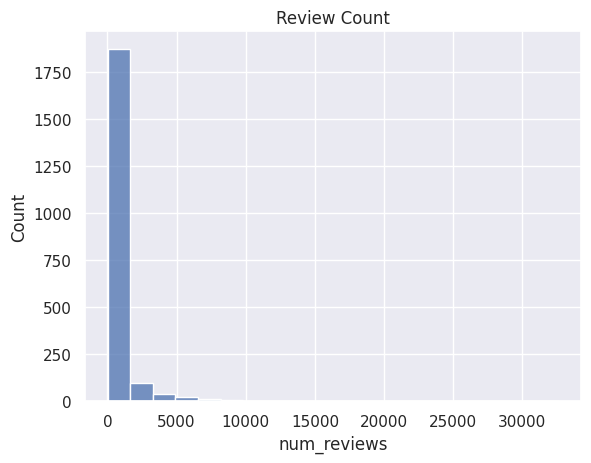

In [23]:
sns.set(style="darkgrid")

sns.histplot(data=wine1, x="num_reviews",bins=20).set_title('Review Count')
plt.show()

## Categorical variable visuals

Following countplots adapted from: https://datagy.io/seaborn-countplot/ and from notes/classes

### Wine type Countplot

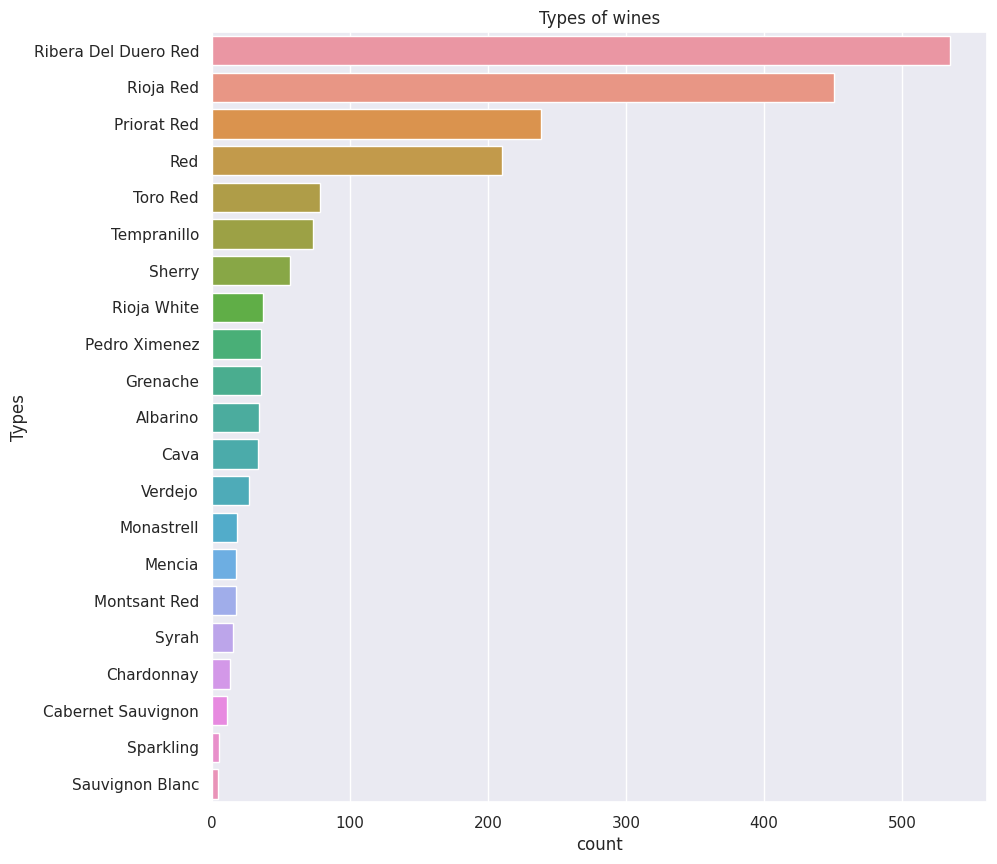

In [24]:
fig, ax = plt.subplots(figsize=(10,10))

sns.countplot(data = wine1, y = 'type', order = wine1['type'].value_counts().index)

ax.set(title = 'Types of wines')
ax.set(ylabel = 'Types');

## You can see Using the Graph above the most common of wine type of the DataSet are Reds.

### Heatmap comparing all numeric variable


<ipython-input-25-6326f05ced55>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = wine1.corr()


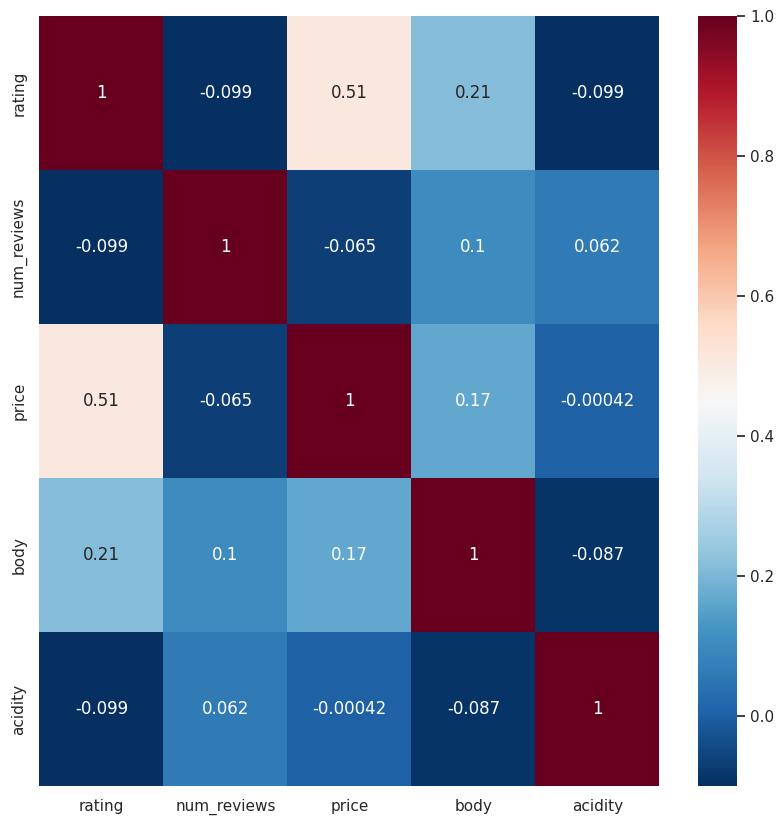

In [25]:
corr = wine1.corr()
sns.set(font_scale=1)
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap = 'RdBu_r', annot = True);

Using the heatmap above you can see there is a moderate correlation between the price and the rating. This usually means the better rated the wine is the more expensive. Thats not to say you cant find a hidden gem for cheaper.

### boxplot comparing body, rating, and acidity

Code adapted from: https://www.analyticsvidhya.com/blog/2021/06/eda-exploratory-data-analysis-with-python/

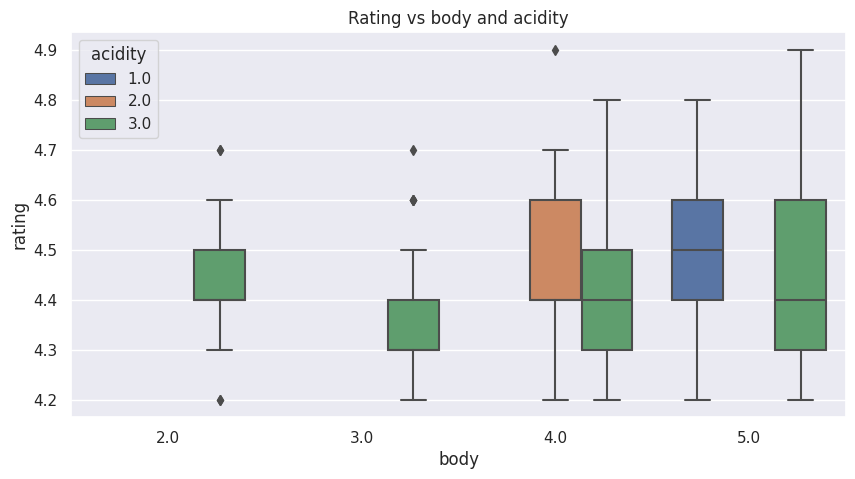

In [26]:
plt.figure(figsize=(10,5))
sns.boxplot(data =wine1, x='body', y='rating', hue ='acidity')
plt.title('Rating vs body and acidity')
plt.show()

### This boxplot shows the higher rated wines tend to have more body.


### Pairplot
code adapted from: https://towardsdatascience.com/10-must-know-seaborn-functions-for-multivariate-data-analysis-in-python-7ba94847b117 

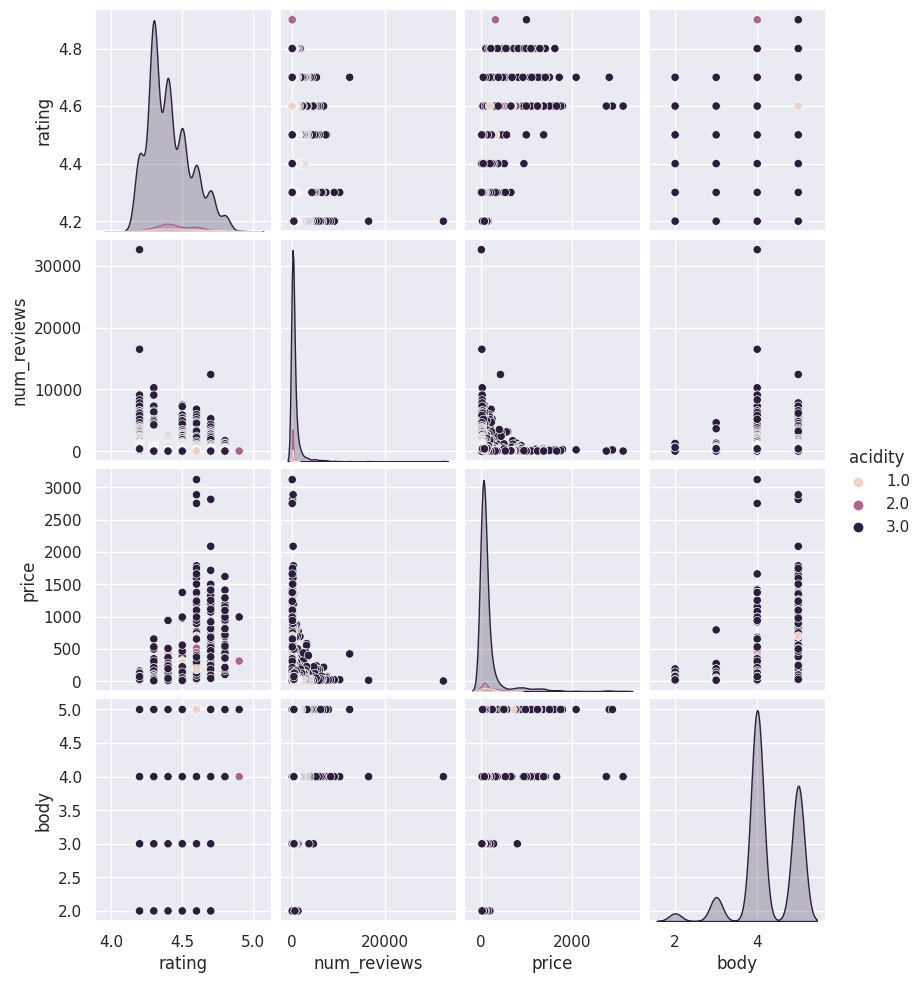

In [27]:
sns.pairplot(
    data=wine1, 
    aspect=.85,
    hue='acidity');

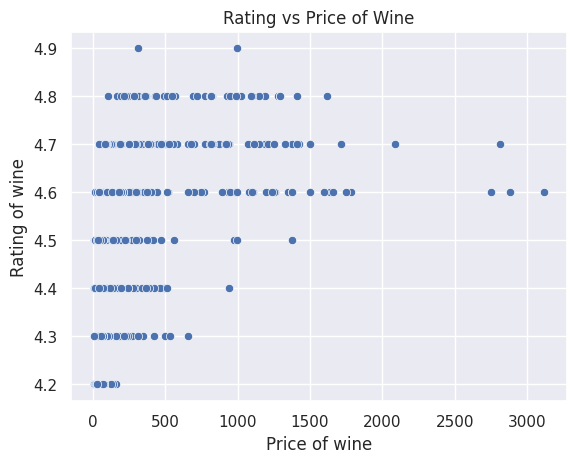

In [28]:
sns.set(font_scale=1)
sns.scatterplot(x='price', y='rating', 
    data=wine1).set(title='Rating vs Price of Wine')
plt.xlabel(
    'Price of wine')
plt.ylabel('Rating of wine');

With the scatter plot above you see of the 2 highest rated wines cost roughly 450.00 and 1000.00

You can also see the price of the wine does not alway correlate to higest ratings.

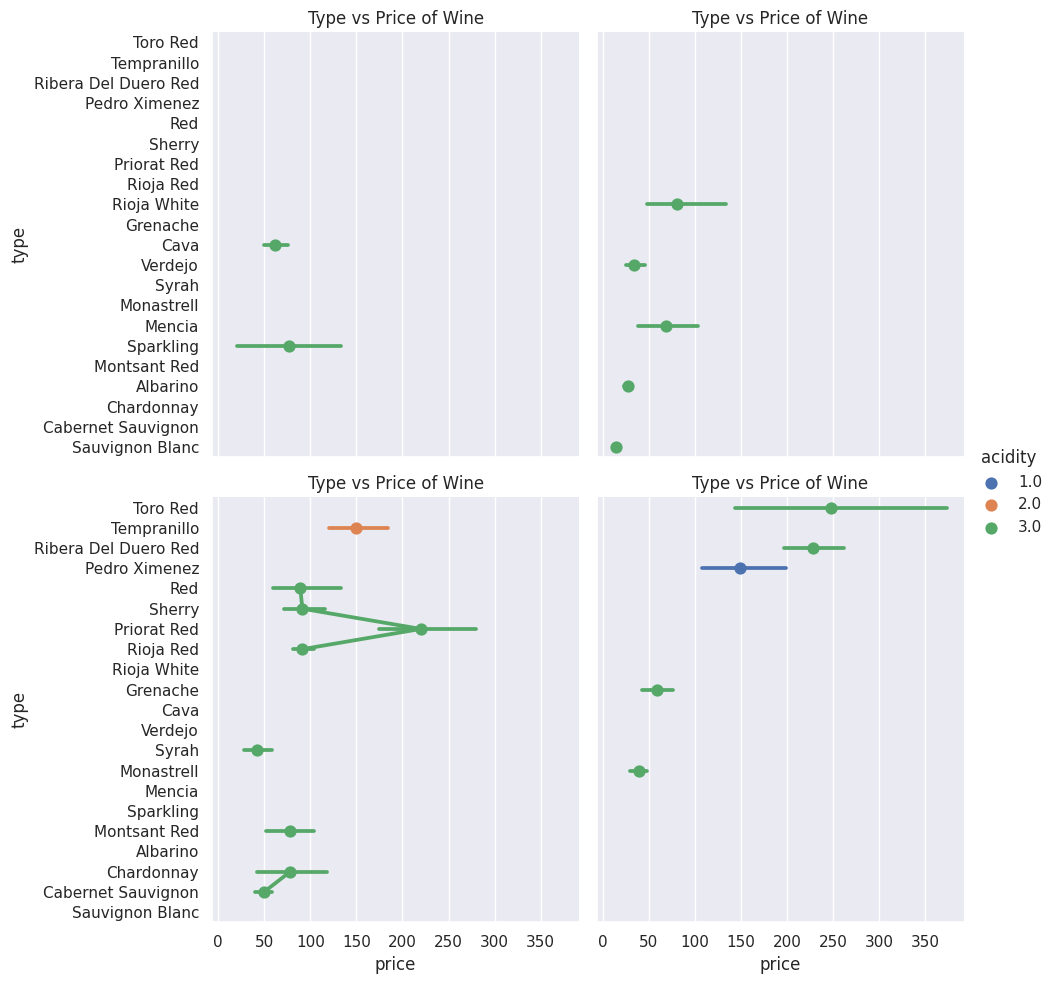

In [29]:
sns.catplot(x='price', y='type', data=wine1, height=5, 
            aspect=1, kind='point', hue='acidity', col='body', col_wrap=2).set(title='Type vs Price of Wine');

Text(0, 0.5, 'Type of wine')

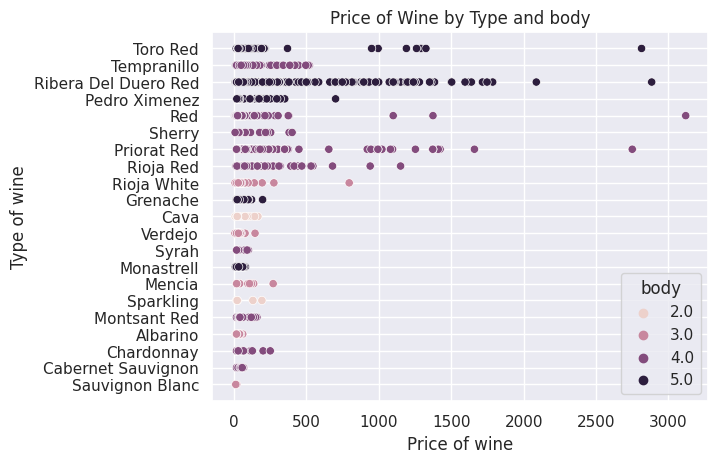

In [30]:
sns.set(font_scale=1)
sns.scatterplot(x='price', y='type', hue='body',
                data=wine1).set(title='Price of Wine by Type and body')
plt.xlabel(
    'Price of wine')
plt.ylabel('Type of wine')

Using the scatterplot above you can see Reds tend to have more body while having the biggest price range

## Preprocessing

## Models

### Model cleaning
Using orginal dataframe "wine"

In [31]:
# added this to copy - can toss -
wine.describe(include='object')

,winery,wine,year,region,type
count,2048,2048,2046,2048,1942
unique,480,847,71,76,21
top,Vega Sicilia,Tinto,2016,Ribera del Duero,Ribera Del Duero Red
freq,97,56,243,541,535


In [32]:
# added this to copy - can toss -
wine.describe()

,rating,num_reviews,price,body,acidity
count,2048.000000,2048.000000,2048.000000,1777.000000,1777.000000
mean,4.401123,573.994629,135.242194,4.258863,2.921216
std,0.147023,1376.153171,272.178316,0.652836,0.334713
min,4.200000,25.000000,4.990000,2.000000,1.000000
25%,4.300000,58.000000,31.917947,4.000000,3.000000
50%,4.400000,141.000000,53.625000,4.000000,3.000000
75%,4.500000,485.500000,110.000000,5.000000,3.000000
max,4.900000,32624.000000,3119.080000,5.000000,3.000000


### Reveiwed the data on a few features and made adjustments below

In [33]:
# added to copy of copy - probably keeping
# Reducing wine types 
wine['type'].replace({'Toro Red':'Red', 'Tempranillo': 'Red', 'Rioja Red':'Red',
                      'Ribera Del Duero Red':'Red', 'Priorat Red':'Red',
                      'Montsant Red':'Red', 'Monastrell':'Red','Mencia':'Red',
                      'Grenache':'Red', 'Cabernet Sauvignon':'Red',
                      'Syrah':'Red', 'Verdejo':'White', 'Sherry':'White',
                      'Sauvignon Blanc':'White', 'Rioja White':'White',
                      'Pedro Ximenez':'White','Chardonnay':'White',
                      'Albarino':'White', 'Cava':'Sparkling'}, inplace=True)

# Filling in missing wine types
wine['type'].fillna('White', inplace = True)

In [34]:
wine['rating'].replace({4.3:'Low', 4.2: 'Low', 4.4: 'Mid',
                      4.5: 'Mid', 4.6: 'High',4.7: 'High',
                      4.8: 'High', 4.9: 'High'}, inplace=True)


In [35]:
## Replace inconsistent value in year
wine['year'].replace('N.V.', '2010',inplace=True)
wine['year'].fillna('2010', inplace = True)
## Coverting 'object' to 'float' for year column
wine['year'] = wine['year'].astype(int)


In [36]:
# Rounding wine years to the nearest decade
wine['year'] = wine['year'].round(-1)
wine.head()

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity
0,Teso La Monja,Tinto,2010,High,58,Toro,995.00,Red,5.0,3.0
1,Artadi,Vina El Pison,2020,High,31,Vino de Espana,313.50,Red,4.0,2.0
2,Vega Sicilia,Unico,2010,High,1793,Ribera del Duero,324.95,Red,5.0,3.0
3,Vega Sicilia,Unico,2000,High,1705,Ribera del Duero,692.96,Red,5.0,3.0
4,Vega Sicilia,Unico,2000,High,1309,Ribera del Duero,778.06,Red,5.0,3.0


In [37]:
values = [1950,1930, 1920, 1940, 1910]

#drop any rows that have 7 or 11 in the rebounds column
wine = wine[wine.year.isin(values) == False]

In [38]:
# Convert year to categorical since the are not linear
wine['year'] = wine['year'].astype('object')

<ipython-input-38-5070e71c73b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine['year'] = wine['year'].astype('object')


In [39]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2035 entries, 0 to 6100
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   winery       2035 non-null   object 
 1   wine         2035 non-null   object 
 2   year         2035 non-null   object 
 3   rating       2035 non-null   object 
 4   num_reviews  2035 non-null   int64  
 5   region       2035 non-null   object 
 6   price        2035 non-null   float64
 7   type         2035 non-null   object 
 8   body         1764 non-null   float64
 9   acidity      1764 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 174.9+ KB


In [40]:
# Rounding number of reviews to the nearest
wine['num_reviews'] = wine['num_reviews'].round(-1)

# Rounding the price to the nearest dollar
wine['price'] = wine['price'].round(decimals = -1)

<ipython-input-40-32720611a853>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine['num_reviews'] = wine['num_reviews'].round(-1)
<ipython-input-40-32720611a853>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wine['price'] = wine['price'].round(decimals = -1)


In [41]:
# Checking data
wine.describe(include='all')

,winery,wine,year,rating,num_reviews,region,price,type,body,acidity
count,2035,2035,2035.0,2035,2035.000000,2035,2035.000000,2035,1764.000000,1764.000000
unique,478,844,7.0,3,NaN,76,NaN,3,NaN,NaN
top,Vega Sicilia,Tinto,2020.0,Low,NaN,Ribera del Duero,NaN,Red,NaN,NaN
freq,96,56,1039.0,933,NaN,540,NaN,1692,NaN,NaN
mean,NaN,NaN,NaN,NaN,577.071253,NaN,133.390663,NaN,4.256236,2.928571
std,NaN,NaN,NaN,NaN,1379.855981,NaN,271.099952,NaN,0.653183,0.313254
min,NaN,NaN,NaN,NaN,20.000000,NaN,0.000000,NaN,2.000000,1.000000
25%,NaN,NaN,NaN,NaN,60.000000,NaN,30.000000,NaN,4.000000,3.000000
50%,NaN,NaN,NaN,NaN,140.000000,NaN,50.000000,NaN,4.000000,3.000000
75%,NaN,NaN,NaN,NaN,490.000000,NaN,110.000000,NaN,5.000000,3.000000


In [42]:
def model_metrics(pipe, X_train, y_train, X_test, y_test,
                  model_name = 'Decision Tree Classifier',):
  train_pred = pipe.predict(X_train)
  test_pred = pipe.predict(X_test)

  metrics = ['train_accuracy', 'test_accuracy',
             'train_precision', 'test_precision',
             'train_recall', 'test_recall',
             'train_f1', 'test_f1']
  ## Train
  train_accuracy = accuracy_score(y_train, train_pred)
  train_precision = precision_score(y_train, train_pred)
  train_recall = recall_score(y_train, train_pred)
  train_f1 = f1_score(y_train, train_pred)

  ## Test
  test_accuracy = accuracy_score(y_test, test_pred)
  test_precision = precision_score(y_test, test_pred)
  test_recall = recall_score(y_test, test_pred)
  test_f1 = f1_score(y_test, test_pred)


  scores = pd.DataFrame(index=metrics, columns=[f'{model_name}_test'])
  scores.loc[metrics, f'{model_name}_test'] = [train_accuracy, test_accuracy,
                                               train_precision, test_precision,
                                               train_recall, test_recall,
                                               train_f1, test_f1]

  return scores                                              

## Train, Test, Split

In [43]:
# set features and targets
X = wine.drop(columns=['rating','region', 'winery', 'wine'])
y = wine['rating']
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


## Preprocessors

In [44]:
# Instantiate column selectors
## number & category selector
num_sel = make_column_selector(dtype_include= 'number' )
cat_sel = make_column_selector(dtype_include='object')

# Instantiate Mean Imputer
median_imp = SimpleImputer(strategy='median')

# Instantiate Transformers
## Scaler for numeric
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown= 'ignore', sparse_output=False)

# Pipeline
num_pipe = make_pipeline(median_imp, scaler)

# Tuple for column transformer
num_tup = (num_pipe, num_sel)
cat_tup = (ohe, cat_sel)

# ColumnTransformer
preprocessor = make_column_transformer(num_tup, cat_tup, remainder='passthrough')

In [45]:
# fitting my X_train model
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd340>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd730>)])

In [46]:
# transform X_train and test
X_train_processed = preprocessor.transform(X_train)

## Random Forest Regressor Model

In [47]:
# Create an instance of the model
rf = RandomForestClassifier()
# Create a model pipeline
rf_pipe = make_pipeline(preprocessor, rf)
# Fit the model
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd340>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd730>)])),
                ('randomforestclassifier', RandomForestClassifier())])

### Random forest predictions

              precision    recall  f1-score   support

        High       0.96      0.93      0.95       254
         Low       0.94      0.95      0.94       701
         Mid       0.92      0.92      0.92       571

    accuracy                           0.94      1526
   macro avg       0.94      0.93      0.94      1526
weighted avg       0.94      0.94      0.94      1526



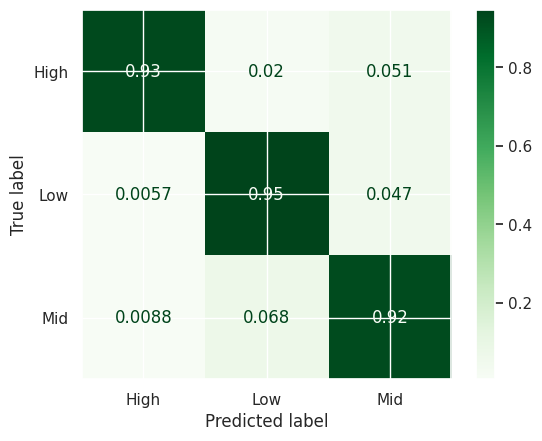

In [49]:
# Evaluate the decision tree on the training data using classification_report()
# and a confusion matrix
rf_preds = rf_pipe.predict(X_train)

print(classification_report(y_train, rf_preds))

ConfusionMatrixDisplay.from_predictions(y_train, rf_preds,
                                        cmap='Greens',
                                        normalize='true');

In [50]:
# Params for tuning
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd340>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd730>)])),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'columntransformer': ColumnTr

### RF using GrisSearch

In [51]:
# Tune rf with GridSearchCV
rf_param_grid = {'randomforestclassifier__max_features': [2,3,5,7,9],
                 'randomforestclassifier__max_depth': [2,3,5,7,9]}

# GridSearch using pipeline and param grid
rf_gs = GridSearchCV(rf_pipe, rf_param_grid)

# fitting GSCV
rf_gs.fit(X_train, y_train)

# print best parameters
print('Best Random Forest Parameters:')
print(rf_gs.best_params_)

# print accuracy using .best_estimator
rf_best = rf_gs.best_estimator_
print(f'Accuracy of Random Forest Model: {rf_best.score(X_test, y_test)}')

Best Random Forest Parameters:
{'randomforestclassifier__max_depth': 9, 'randomforestclassifier__max_features': 3}
Accuracy of Random Forest Model: 0.5834970530451866


## Tuned RF w/ GridSearch

In [52]:
rf_tuned = RandomForestClassifier(max_features=3, max_depth=9, random_state=42)

rf_gs_pipe = make_pipeline(preprocessor, rf_tuned)

In [53]:
rf_gs_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd340>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd730>)])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=9, max_features=3,
                                        random_state=42))])

              precision    recall  f1-score   support

        High       0.96      0.67      0.79       254
         Low       0.78      0.86      0.82       701
         Mid       0.71      0.71      0.71       571

    accuracy                           0.78      1526
   macro avg       0.82      0.75      0.77      1526
weighted avg       0.78      0.78      0.78      1526



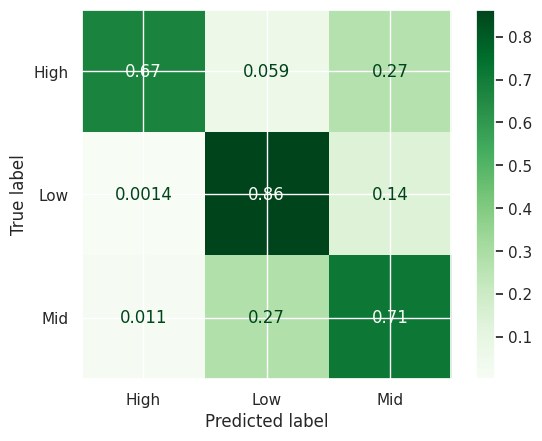

In [54]:
# Evaluate the decision tree on the training data using classification_report()
# and a confusion matrix
rf_gs_pred = rf_gs_pipe.predict(X_train)

print(classification_report(y_train, rf_gs_pred))

ConfusionMatrixDisplay.from_predictions(y_train, rf_gs_pred,
                                        cmap='Greens',
                                        normalize='true');

## RF with PCA

In [55]:
pca = PCA(n_components=7)

transformer = make_pipeline(preprocessor, pca)

rf_pca = RandomForestClassifier(random_state = 42)

rf_pcs = make_pipeline(transformer, rf_pca)

rf_pcs.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('pipeline',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd340>),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd730>)])),
                                 ('pca', PCA(n_components=7))])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

              precision    recall  f1-score   support

        High       0.97      0.92      0.95       254
         Low       0.93      0.96      0.94       701
         Mid       0.93      0.91      0.92       571

    accuracy                           0.93      1526
   macro avg       0.94      0.93      0.94      1526
weighted avg       0.93      0.93      0.93      1526



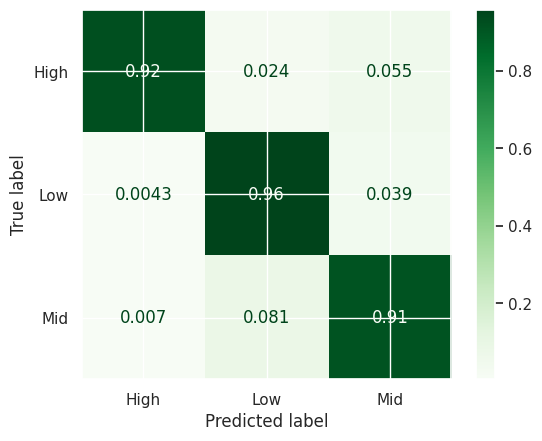

In [56]:
# Evaluate the decision tree on the training data using classification_report()
# and a confusion matrix
rf_pred = rf_pcs.predict(X_train)

print(classification_report(y_train, rf_pred))

ConfusionMatrixDisplay.from_predictions(y_train, rf_pred,
                                        cmap='Greens',
                                        normalize='true');

Using the results above the best model would be the Random Forest with PCA with a testing accuracy of 93 percent. Also all of my false predictions are under 1 percent.

## KNN Model

In [57]:
# Model
knn = KNeighborsClassifier()
# Pipeline for preprocessor and model
knn_pipe = make_pipeline(preprocessor, knn)
# Fitting pipeline
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd340>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd730>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

              precision    recall  f1-score   support

        High       0.70      0.70      0.70       254
         Low       0.73      0.81      0.77       701
         Mid       0.69      0.60      0.64       571

    accuracy                           0.71      1526
   macro avg       0.71      0.70      0.70      1526
weighted avg       0.71      0.71      0.71      1526



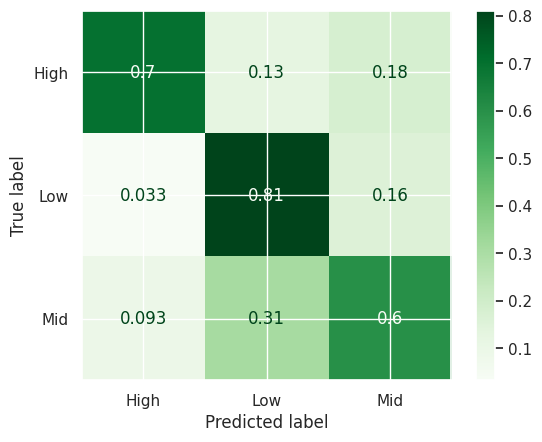

In [58]:
# Evaluate the decision tree on the training data using classification_report()
# and a confusion matrix
knn_preds = knn_pipe.predict(X_train)

print(classification_report(y_train, knn_preds))

ConfusionMatrixDisplay.from_predictions(y_train, knn_preds,
                                        cmap='Greens',
                                        normalize='true');

In [59]:
# Looking at options for tuning this model
knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd340>),
                                   ('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse_output=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd730>)])),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'columntransformer': ColumnTransf

### KNN tuning with GridSearch

In [60]:
# Tune DT with GridSearchCV
knn_param_grid = {'kneighborsclassifier__n_neighbors': [2,3,5]}

# GridSearch using pipeline and param grid
knn_gs = GridSearchCV(knn_pipe, knn_param_grid)

# fitting GSCV
knn_gs.fit(X_train, y_train)

# print best parameters
print('Best Random Forest Parameters:')
print(knn_gs.best_params_)

# print accuracy using .best_estimator
dt_best = knn_gs.best_estimator_
print(f'Accuracy of Random Forest Model: {rf_best.score(X_test, y_test)}')

Best Random Forest Parameters:
{'kneighborsclassifier__n_neighbors': 5}
Accuracy of Random Forest Model: 0.5834970530451866


## KNN with GSCV

In [61]:
knn_gs_t = KNeighborsClassifier(n_neighbors= 5)

knn_gs_pipe = make_pipeline(preprocessor, knn_gs_t)

knn_gs_pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd340>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd730>)])),
                ('kneighborsclassifier', KNeighborsClassifier())])

              precision    recall  f1-score   support

        High       0.70      0.70      0.70       254
         Low       0.73      0.81      0.77       701
         Mid       0.69      0.60      0.64       571

    accuracy                           0.71      1526
   macro avg       0.71      0.70      0.70      1526
weighted avg       0.71      0.71      0.71      1526



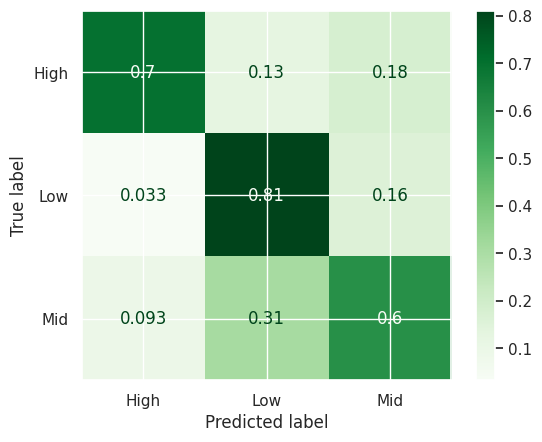

In [62]:
# Evaluate the decision tree on the training data using classification_report()
# and a confusion matrix
knngs_pred = knn_gs_pipe.predict(X_train)

print(classification_report(y_train, knngs_pred))

ConfusionMatrixDisplay.from_predictions(y_train, knngs_pred,
                                        cmap='Greens',
                                        normalize='true');

## KNN with PCA

In [66]:
pca = PCA(n_components=7)

transformer = make_pipeline(preprocessor, pca)

knn_pca = KNeighborsClassifier()

knn_pcs = make_pipeline(transformer, knn_pca)
# train with PCA
knn_pcs.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('pipeline',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('standardscaler',
                                                                                    StandardScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd340>),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7f8fdbbdd730>)])),
                                 ('pca', PCA(n_components=7))])),
                ('kneighborsclassifier', KNeighborsClassifier())])

              precision    recall  f1-score   support

        High       0.70      0.69      0.69       254
         Low       0.74      0.80      0.77       701
         Mid       0.68      0.61      0.65       571

    accuracy                           0.71      1526
   macro avg       0.71      0.70      0.70      1526
weighted avg       0.71      0.71      0.71      1526



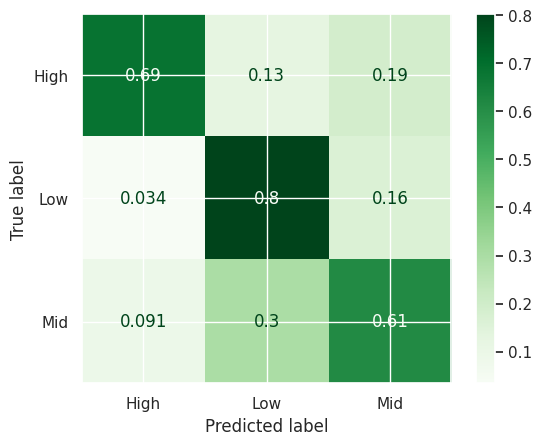

In [67]:
# Evaluate the decision tree on the training data using classification_report()
# and a confusion matrix
knn_pred = knn_pcs.predict(X_train)

print(classification_report(y_train, knn_pred))

ConfusionMatrixDisplay.from_predictions(y_train, knn_pred,
                                        cmap='Greens',
                                        normalize='true');

The best KNN model was using GridSearch with a testing accuracy of 71 percent. My false positives are anywhere from 1 to 30 percent. Knowing this I would present my Random Forest Model

## Summary

I would chose the random forest model.